Бизнес-задача: Прогнозирование оттока клиентов (Customer Churn Prediction)
Описание задачи:

Компании, предоставляющие услуги по подписке (например, интернет-провайдеры, мобильные операторы, стриминговые сервисы), часто сталкиваются с проблемой оттока клиентов. Задача состоит в том, чтобы предсказать, какие клиенты, скорее всего, прекратят пользоваться услугами компании в ближайшем будущем. Это позволяет компании своевременно принять меры для удержания этих клиентов, предложив им, например, скидки или улучшенные условия.
Задача машинного обучения:

Необходимо построить модель машинного обучения, которая будет предсказывать, какие клиенты с высокой вероятностью могут прекратить пользоваться услугами компании в ближайшем будущем.
Датасет:

Для данной задачи хорошо подходит датасет Telco Customer Churn, который содержит информацию о клиентах телекоммуникационной компании. Датасет включает демографические данные, информацию об услугах, которыми пользуется клиент, и факт оттока.

Ссылка на датасет: Telco Customer Churn

# Первичный анализ и предобработка

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Первые несколько строк датасета:")
print(df.head())

print("\nОбщая информация о датасете:")
print(df.info())

print("\nСтатистический обзор числовых данных:")
print(df.describe())

print("\nПроверка на наличие пропущенных значений:")
print(df.isnull().sum())

df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

scaler = StandardScaler()
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("\nПервые несколько строк обработанного датасета:")
print(df.head())


ModuleNotFoundError: No module named 'pandas'

# EDA

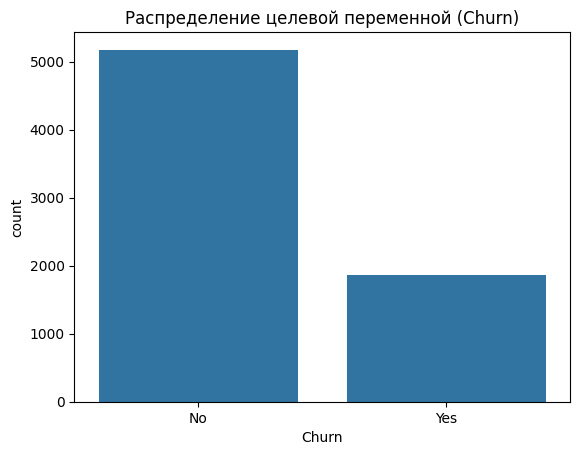

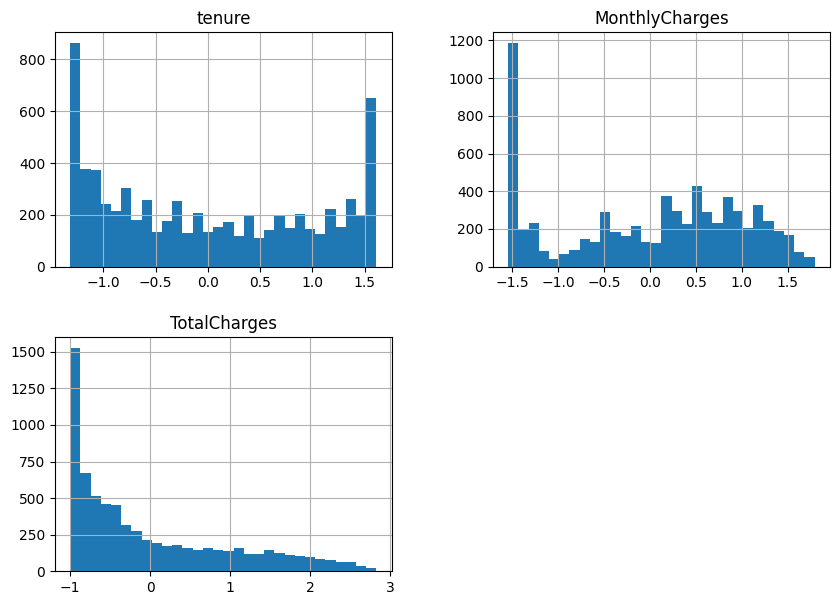

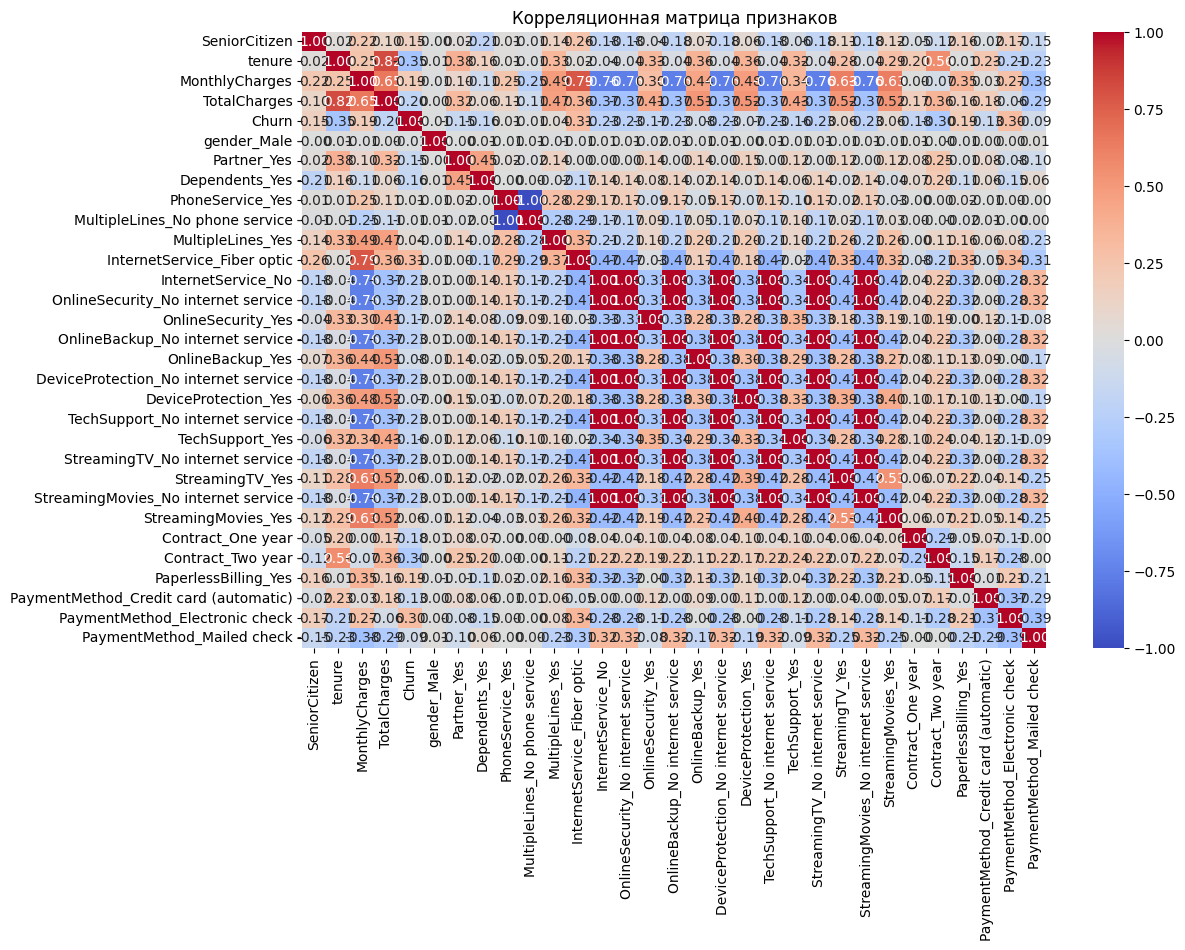

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Распределение целевой переменной (Churn)
sns.countplot(x='Churn', data=df)
plt.title('Распределение целевой переменной (Churn)')
plt.show()

# Распределение числовых признаков
df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=30, figsize=(10, 7))
plt.show()

# Удалим строковые столбцы перед построением корреляционной матрицы
# Кроме того, преобразуем 'Churn' в числовой формат
df_for_corr = df.drop(columns=['customerID'])
df_for_corr['Churn'] = df_for_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Корреляционная матрица
plt.figure(figsize=(12, 8))
sns.heatmap(df_for_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


In [6]:
# Создание нового признака "NewCustomer"
df['NewCustomer'] = df['tenure'].apply(lambda x: 1 if x < 12 else 0)

# Убедимся, что новый признак создан
print(df[['tenure', 'NewCustomer']].head())


     tenure  NewCustomer
0 -1.277445            1
1  0.066327            1
2 -1.236724            1
3  0.514251            1
4 -1.236724            1


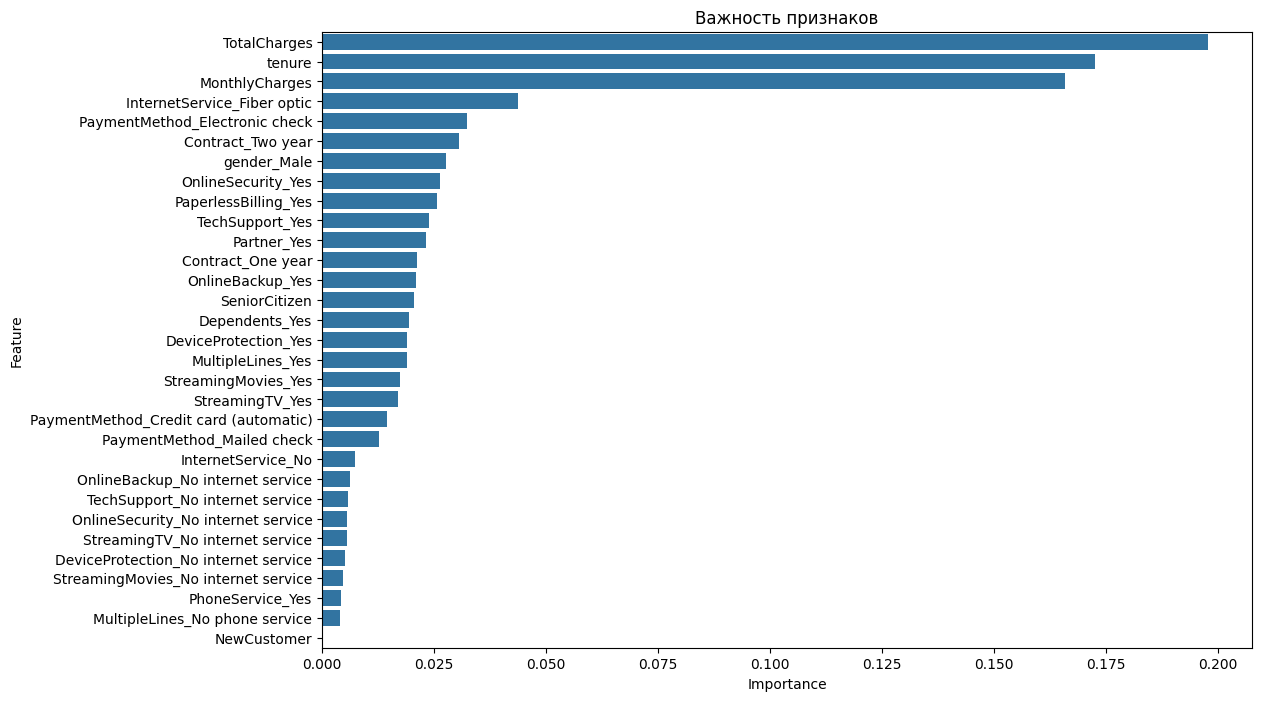

Топ-10 отобранных признаков: ['TotalCharges' 'tenure' 'MonthlyCharges' 'InternetService_Fiber optic'
 'PaymentMethod_Electronic check' 'Contract_Two year' 'gender_Male'
 'OnlineSecurity_Yes' 'PaperlessBilling_Yes' 'TechSupport_Yes']


In [7]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Определим целевую переменную и признаки
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Обучение модели Random Forest для оценки важности признаков
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Оценка важности признаков
importances = model.feature_importances_

# Создание DataFrame для визуализации важности признаков
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков')
plt.show()

# Выбор топ-10 наиболее значимых признаков
selected_features = feature_importance['Feature'].head(10).values

# Обновим данные для моделирования
X = df[selected_features]

print(f"Топ-10 отобранных признаков: {selected_features}")


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Целевая переменная и признаки
X = df[selected_features]
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Размеры обучающей и тестовой выборок после подготовки данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Размеры обучающей и тестовой выборок после подготовки данных:
X_train: (5634, 10), y_train: (5634,)
X_test: (1409, 10), y_test: (1409,)
